**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources: Soner Yıldırım, Bex T, Manuel Hupperich, Youssef Hosni and Piero Paialunga en www.towardsdatascience.com. Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

# Time Series Analysis: LSTM

Long Short Term Memory or LSTM is a type of Neural Network, which was developed on the basis provided by the Recurrent Neural Networks, or RNN. The algorithms main usage falls into NLPs or Time Series, and the main idea behind it relates to processing the information they receive from the previous neuron and applying the activation function from scratch (as the CNN/RNN do), they actually divide the neuron into three main parts from which to set up the input from the next layer of neurons: Learn, Unlearn and Retain gate. The structure of the LSTM layer can be visualized in the image below:

![LSTM](https://miro.medium.com/max/700/0*RkFisWmsLWtGCByq.png)

#### Parameters for the LSTM
* PERCENTAGE = .98 #Split train/val and test set
* CALLBACK = .031 #Used to stop training the Network when the MAE from the validation set reached a perormance below 3.1%
* BATCH_SIZE = 20 #Number of samples that will be propagated through the network. I chose almost a trading month
* EPOCH = 50 #Settled to train the model
* WINDOW_LSTM = 30 #The window used for the input data
* PREDICTION_SCOPE = 0 #How many period to predict, being 0=1

In [12]:
import keras
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout
#from keras.optimizers import SGD

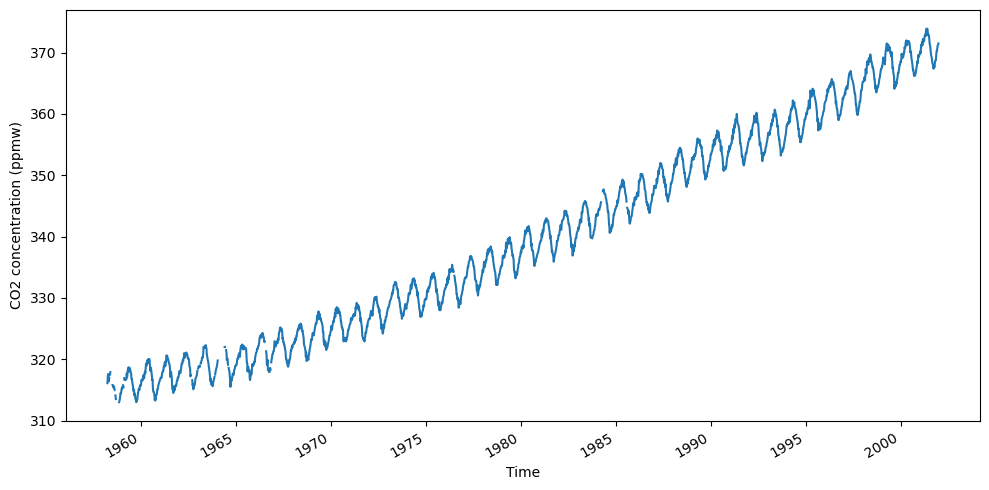

In [13]:
data = sm.datasets.co2.load_pandas().data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')
fig.autofmt_xdate()
plt.tight_layout()